In [1]:
from train.data.supervised import ResampledAframeDataset_v3

/usr/local/lib/python3.10/site-packages/lalsimulation/lalsimulation.py:8: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal
PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1
/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from ml4gw.distributions import PowerLaw
import torch
from lightning.pytorch.trainer import Trainer
from train.callbacks import ModelCheckpoint, SaveAugmentedBatch
from train.model import SupervisedAframe
from architectures.bandpass import Bandpass
from ml4gw.nn.norm import GroupNorm1DGetter
from train.metrics import TimeSlideAUROC
from lightning.pytorch.loggers import CSVLogger
import sys
sys.path.append('/home/seiya.tsukamoto/aframe/libs/priors/')
from priors.priors import end_o3_ratesandpops
import numpy as np
import os
import gc
from matplotlib import pyplot as plt
plt.plot(0)
plt.close()
from collections import defaultdict
from torchmetrics.classification import BinaryAUROC
from scipy.signal import decimate
import torchaudio.transforms as T

In [4]:
arch = Bandpass(classes = 64, num_ifos = 2, layers = [3, 4, 6, 3], norm_layer = GroupNorm1DGetter(groups = 16), 
                                  sample_rate = 2048, kernel_length = 4)
metric = TimeSlideAUROC(max_fpr = 1e-3, pool_length = 8, stride = 0.5)
weight_decay = 0.0
learning_rate = 0.000585
pct_lr_ramp = 0.115


batch_size = 512
batches_per_epoch = 10
num_files_per_batch = 10
chunk_size = 10000
chunks_per_epoch = 10
psd_length = 8
fftlength = None

waveform_prob = 0.277
swap_prob = 0.014
mute_prob = 0.055
left_pad = 0.25
right_pad = 0.05
snr_sampler = PowerLaw(minimum = 4, maximum = 100, index = -3)
valid_frac = 0.25
valid_stride = 0.5
num_valid_views = 5
valid_livetime = 10000



logger = CSVLogger(save_dir = '/home/seiya.tsukamoto/aframe/layered/test_runs', flush_logs_every_n_steps = 10)
callbacks = [ModelCheckpoint(monitor = "valid_auroc", mode = "max", save_top_k = 1, save_last = True, auto_insert_metric_name = False),
             SaveAugmentedBatch()]
max_epochs = 1
check_val_every_n_epoch = 1
log_every_n_steps = 20



ifos = ["H1", "L1"]
train_start = 1240579783
train_stop = 1241443783
test_stop = 1244035783 
max_duration = 10000
Tb = 31536000
shifts = [0, 1]
seed = 1122

streams_per_gpu = 1

kernel_length = [4, 2, 1]
prior = end_o3_ratesandpops

fftlength = None 
sample_rate = [512, 1024, 2048]
fduration = 1
highpass = [32, 64, 128]
lowpass = [64, 128, 1024]
band = 0

inference_psd_length = 64
inference_sampling_rate = 4
inference_batch_size = 128

waveform_duration = 10
coalescence_time = 8
min_valid_duration = 1000.0

data_dir = '/home/seiya.tsukamoto/aframe/layered/data/train'

In [5]:
module = SupervisedAframe(arch = arch, metric = metric, learning_rate = learning_rate, 
                          pct_lr_ramp = pct_lr_ramp, weight_decay = weight_decay, verbose = True)

In [6]:
RSAD = ResampledAframeDataset_v3(data_dir = data_dir, ifos = ifos, sample_rate = sample_rate[band],
                                 valid_frac = valid_frac, batches_per_epoch = batches_per_epoch, 
                                 num_files_per_batch = num_files_per_batch, batch_size = batch_size,
                                 kernel_length = kernel_length[band], fduration = fduration, psd_length = psd_length, 
                                 waveform_prob = waveform_prob, max_snr = None, snr_alpha = None,
                                 left_pad = left_pad, right_pad = right_pad, fftlength = fftlength,
                                 highpass = highpass[band], lowpass = lowpass[band], snr_sampler = snr_sampler, 
                                 valid_stride = valid_stride, num_valid_views = num_valid_views, 
                                 min_valid_duration = min_valid_duration, valid_livetime = valid_livetime, 
                                 verbose = True, chunks_per_epoch = chunks_per_epoch,chunk_size = chunk_size, 
                                file_sample_rate = 2048)

2025-08-31 22:15:01,459 - root - INFO - Downloading data to /home/seiya.tsukamoto/aframe/layered/data/train


In [7]:
trainer = Trainer(accelerator = 'cpu', strategy = 'ddp_notebook', devices = 1, num_nodes = 1, logger = logger, 
                  callbacks = callbacks, max_epochs = 1, check_val_every_n_epoch = 1, log_every_n_steps = 20, 
                  benchmark = True, fast_dev_run = False)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [8]:
#import os

In [9]:
#os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [10]:
#trainer.fit(module, datamodule=RSAD)

In [11]:
#asd = torch.jit.load('/home/seiya.tsukamoto/aframe/layered/test_runs/model.pt')
#module.model.load_state_dict(asd.state_dict())
#module.model.eval()
#_ = module.to(torch.device('cuda:0'))

In [12]:
trainer.strategy._lightning_module = module
RSAD.trainer = trainer
RSAD.prepare_data()
RSAD.setup(stage = 'train')

2025-08-31 22:15:04,088 - AframeDataset - INFO - Constructing sample rate dependent transforms
2025-08-31 22:15:04,125 - AframeDataset - INFO - Loading validation background data
2025-08-31 22:15:04,680 - AframeDataset - INFO - Constructing validation timeslides from background segments /home/seiya.tsukamoto/aframe/layered/data/train/background/background-1241437182-6601.hdf5
2025-08-31 22:15:05,356 - h5py._conv - DEBUG - Creating converter from 3 to 5
2025-08-31 22:15:35,957 - AframeDataset - INFO - Validating on 20000 waveforms
2025-08-31 22:15:35,958 - AframeDataset - INFO - Loading 20000 validation signals
2025-08-31 22:15:36,291 - AframeDataset - INFO - Initial dataloading complete


2025-08-31 22:15:40,245 - AframeDataset - DEBUG - Using 6 workers for strain data loading
2025-08-31 22:15:41,339 - AframeDataset - INFO - Training on pool of 100000 waveforms. Sampling 2 batches per chunk from 10 chunks of size 10000 each epoch


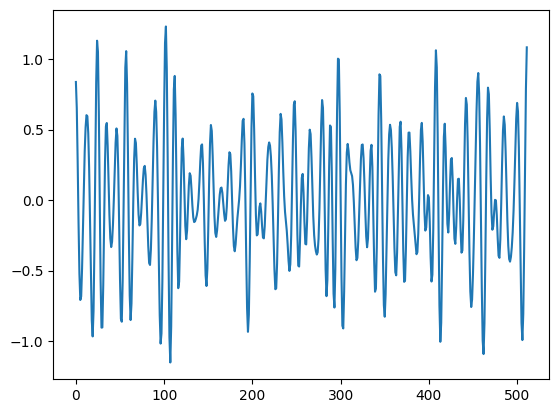

In [13]:
RSAD.trainer.training = True
RSAD.trainer.validating = False
ds = RSAD.train_dataloader()
with torch.no_grad():
    for batch in ds:
        batch = RSAD.on_before_batch_transfer(batch, 10)
        batch = RSAD.on_after_batch_transfer(batch, 10)
        X, waveforms = batch
        break
plt.plot(X[0][0][:512].numpy())

In [14]:
import time
RSAD.trainer.training = True
RSAD.trainer.validating = False
ds = RSAD.train_dataloader()
t1 = time.time()
for batch in ds:
    start_time = time.time()
    batch = RSAD.on_before_batch_transfer(batch, 10)
    end_time = time.time()
    print(f'on_before_batch_transfer {end_time-start_time}')
    start_time = time.time()
    batch = RSAD.on_after_batch_transfer(batch, 10)
    end_time = time.time()
    print(f'on_after_batch_transfer {end_time-start_time}')
t2 = time.time()
t2-t1

2025-08-31 22:16:46,714 - AframeDataset - DEBUG - Using 6 workers for strain data loading
2025-08-31 22:16:46,726 - AframeDataset - INFO - Training on pool of 100000 waveforms. Sampling 2 batches per chunk from 10 chunks of size 10000 each epoch
on_before_batch_transfer 0.03510236740112305
on_after_batch_transfer 0.38497471809387207
on_before_batch_transfer 0.024258136749267578
on_after_batch_transfer 0.08605194091796875
on_before_batch_transfer 0.029760122299194336
on_after_batch_transfer 0.2586863040924072
on_before_batch_transfer 0.027740001678466797
on_after_batch_transfer 0.08736395835876465
on_before_batch_transfer 0.026270151138305664
on_after_batch_transfer 0.1622476577758789
on_before_batch_transfer 0.013336420059204102
on_after_batch_transfer 0.09874868392944336
on_before_batch_transfer 0.21950316429138184
on_after_batch_transfer 0.1367037296295166
on_before_batch_transfer 0.011948347091674805
on_after_batch_transfer 0.08462715148925781
on_before_batch_transfer 0.019533395767

60.25142502784729

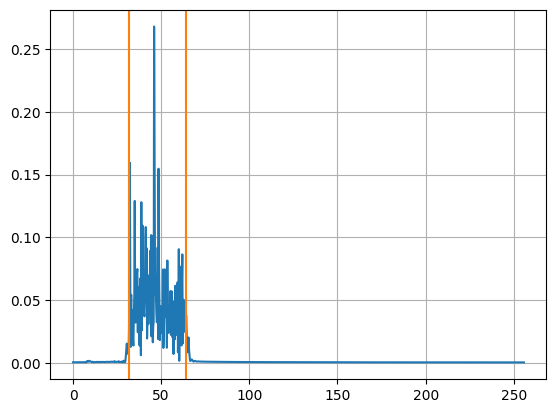

In [15]:
from scipy.fft import fft, fftfreq
import numpy as np
N = 2048
T = 1.0 / 512.0
yf = fft(X[0][0].cpu().numpy())
xf = fftfreq(N, T)[:N//2]
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.axvline(32, c = 'C1')
plt.axvline(64, c = 'C1')
plt.grid()
plt.show()

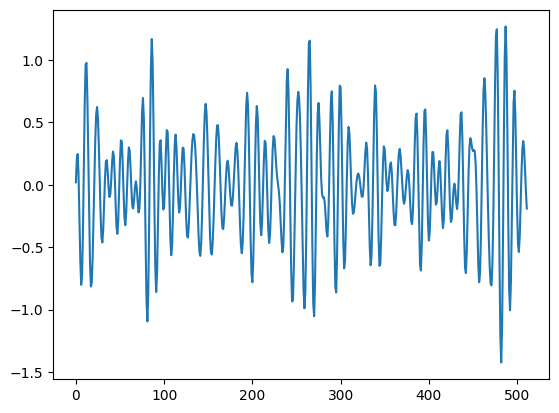

In [16]:
RSAD.trainer.training = False
RSAD.trainer.validating = True
ds = RSAD.val_dataloader()
with torch.no_grad():
    for batch in ds:
        batch = RSAD.on_before_batch_transfer(batch, 10)
        batch = RSAD.on_after_batch_transfer(batch, 10)
        shift, X_bg, X_inj = batch
        break
plt.plot(X_inj[0][0][0][:512].cpu().numpy())

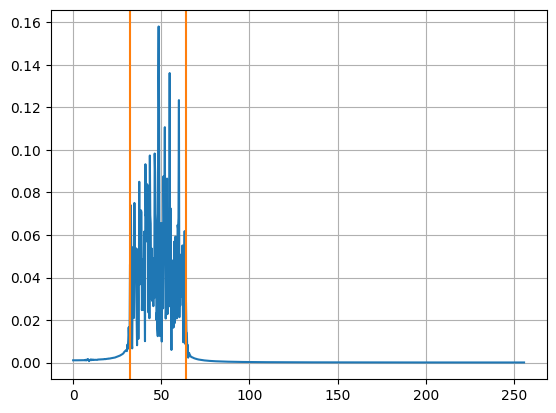

In [19]:
from scipy.fft import fft, fftfreq
import numpy as np
N = 2048
T = 1.0 / 512.0
yf = fft(X_inj[0][0][0].cpu().numpy())
xf = fftfreq(N, T)[:N//2]
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.axvline(32, c = 'C1')
plt.axvline(64, c = 'C1')
plt.grid()
plt.show()

In [20]:
RSAD.trainer.training = False
RSAD.trainer.validating = True
ds = RSAD.val_dataloader()

i = 0
metric = TimeSlideAUROC(max_fpr = 1e-3, pool_length = 8, stride = 0.5)
with torch.no_grad():
    for batch in ds:
        batch = RSAD.on_before_batch_transfer(batch, 10)
        [background, _, timeslide_idx], [signals] = batch
        batch = [background.to(torch.device('cuda:0')), 0, timeslide_idx], [signals.to(torch.device('cuda:0'))]
        del background, timeslide_idx, signals
        batch = RSAD.on_after_batch_transfer(batch, 10)
        shift, X_bg, X_inj = batch
        del batch
        y_bg = module.score(X_bg)
        del X_bg
        num_views, batch, *shape = X_inj.shape
        X_inj = X_inj.view(num_views * batch, *shape)
        
        y_fg = module.score(X_inj)
        y_fg = y_fg.view(num_views, batch)
        del num_views, batch, shape
        y_fg = y_fg.mean(0)
        y_bg = y_bg.cpu()
        y_fg = y_fg.cpu()
        metric.update(shift, y_bg.cpu(), y_fg.cpu())
        i += 1
        if i > 10:
            break

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [18]:
foreground, background = [], defaultdict(list)
for i, bg, fg in zip(metric.shifts, metric.background, metric.foreground):
    foreground.append(fg)
    background[i.item()].append(bg)
foreground = torch.cat(foreground)

In [19]:
pooled_background = []
for bg in background.values():
    bg = torch.cat(bg).view(1, 1, -1)
    bg = metric.pool(bg).view(-1)
    pooled_background.append(bg)
background = torch.cat(pooled_background)

In [20]:
y_pred = torch.cat([background, foreground])
y = torch.zeros_like(y_pred)
y[len(background) :] = 1
idx = torch.randperm(len(y_pred))
y_pred = y_pred[idx]
y = y[idx]

In [22]:
metric.metric(y_pred, y)

tensor(0.4997)

In [23]:
foreground

tensor([0.3513, 0.3519, 0.3506, 0.3520, 0.3491, 0.3486, 0.3455, 0.3477, 0.3468,
        0.3435, 0.3397, 0.3462, 0.3458, 0.3455, 0.3452, 0.3444, 0.3466, 0.3385,
        0.3427, 0.3419, 0.3409, 0.3451, 0.3449, 0.3460, 0.3444, 0.3484, 0.3460,
        0.3280, 0.3488, 0.3502, 0.3494, 0.3419, 0.3527, 0.3480, 0.3523, 0.3521,
        0.3470, 0.3413, 0.3505, 0.3482, 0.3491, 0.3490, 0.3470, 0.3461, 0.3437,
        0.3487, 0.3415, 0.3480, 0.3491, 0.3484, 0.3519, 0.3381, 0.3521, 0.3521,
        0.3537, 0.3495, 0.3499, 0.3504, 0.3482, 0.3480, 0.3499, 0.3499, 0.3518,
        0.3507, 0.3505, 0.3487, 0.3514, 0.3492, 0.3454, 0.3468, 0.3472, 0.3423,
        0.3469, 0.3458, 0.3466, 0.3466, 0.3470, 0.3494, 0.3471, 0.3484, 0.3450,
        0.3453, 0.3476, 0.3463, 0.3443, 0.3484, 0.3443, 0.3464, 0.3457, 0.3458,
        0.3466, 0.3457, 0.3471, 0.3487, 0.3499, 0.3469, 0.3478, 0.3481, 0.3472,
        0.3492, 0.3511, 0.3493, 0.3480, 0.3520, 0.3532, 0.3544, 0.3558, 0.3547,
        0.3463, 0.3528])

In [21]:
y

tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0.,
        0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')